<a href="https://colab.research.google.com/github/kevinszuchet/waste-classification/blob/main/Non_and_Biodegradable_Classification_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Images

Kaggle Dataset: https://www.kaggle.com/rayhanzamzamy/non-and-biodegradable-waste-dataset

## Fetch dataset from Kaggle

In [ ]:
#! mkdir ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d rayhanzamzamy/non-and-biodegradable-waste-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! unzip non-and-biodegradable-waste-dataset.zip -d non_and_biodegradable_waste_dataset

In [ ]:
! mkdir -p non_and_biodegradable_waste_dataset/TRAIN/B non_and_biodegradable_waste_dataset/TRAIN/N

! find non_and_biodegradable_waste_dataset/TRAIN.1/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.1/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.2/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.2/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.3/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.3/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.4/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.4/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

In [ ]:
! rm -rf non_and_biodegradable_waste_dataset/TRAIN.*

In [ ]:
! mkdir -p non_and_biodegradable_waste_dataset/TEST_C/Biodegradable non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable
! mkdir -p non_and_biodegradable_waste_dataset/TEST_C/Biodegradable non_and_biodegradable_waste_dataset/TEST_C/Biodegradable

In [ ]:
! find non_and_biodegradable_waste_dataset/TEST/B -name '*ORI*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TEST_C/Biodegradable '{}' +
! find non_and_biodegradable_waste_dataset/TEST/N -name '*ORI*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable '{}' +

In [ ]:
! cp -a /content/non_and_biodegradable_waste_dataset/TEST_C/Biodegradable/. /content/non_and_biodegradable_waste_dataset/TEST_C/Mixed/

In [ ]:
! cp -a /content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/. /content/non_and_biodegradable_waste_dataset/TEST_C/Mixed/

## Fetch saved models from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/baseline-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/vgg16-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/efficientnet-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/inception-v3-model.h5' .

In [ ]:
drive.flush_and_unmount()

# Data Exploration

Some ideas:
- Plot some histograms with the contrast of the images
- Detect some edges in the images trying to think in the future. Will be we able to detect from each image which object is biodegradable and which not?
- ...
- Plot the future NN using https://github.com/alexlenail/NN-SVG and Graphext
- https://www.linkedin.com/posts/philipvollet_datascience-deeplearning-machinelearning-activity-6891784784658735104-rNC-/
- UI with https://www.youtube.com/watch?v=RiCQzBluTxU&list=PLXROitT1fqQyCrPclagPBO7F2OCzQEsDd&index=11

In [ ]:
! pip install tensorflow-addons -q

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report
from tensorflow.keras.optimizers import RMSprop, SGD

# https://www.tensorflow.org/datasets/performances
# https://www.tensorflow.org/guide/data_performance

AUTOTUNE = tf.data.AUTOTUNE

## Globals Setup

In [ ]:
root_dir = '/content/non_and_biodegradable_waste_dataset/'

# Training Subset Directories (1 dim array of directories)
train_dir = os.path.join(root_dir, 'TRAIN')
# Test Subset Directory
test_dir = os.path.join(root_dir, 'TEST_C')

batch_size = 32
seed = 42

# Output image size
image_size = (64, 64)

# Fraction for Validation Subset (0.2 = 20% of Training Subset)
val_split = 0.2

color_mode = 'rgb'

In [ ]:
def display_img(src, ax=None):
  if ax is None:
    f, ax = plt.subplots()

  img = plt.imread(src)
  ax.imshow(img)
  ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
  return img

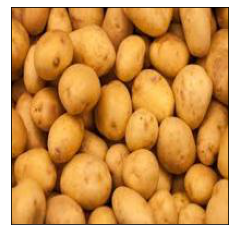

In [ ]:
src = os.path.join(test_dir, 'Biodegradable/TEST_BIODEG_ORI_1000.jpg')
img = display_img(src)

In [ ]:
img.shape

(200, 200, 3)

## Datasets generator

In [ ]:
# Set Up Dataset converting images from Directory to tf.data.Dataset() Object.

train_ds = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='training',
  image_size=image_size,
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='validation',
  image_size=image_size,
  batch_size=batch_size)

## EDA

Exploratory data analysis comprises of brief analyses to describe a dataset to guide the modeling process and to answer preliminary questions. For classification problems, this might include looking at the distributions of variables or checking for any meaningful patterns of predictors across different classes. The same problem holds for the classification of image data. We intend to find meaningful information simple operations can give us.

Here there are some interesting ideas but we would need the data as a numpy array and the size of the dataset is pretty big to apply numpy operations in memory. https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

---

Here we also could get interesting insights of how to explore our dataset https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
f, (ax_bfda, ax_afda) = plt.subplots(1, 2, figsize=(12, 7))

# Get the list of images from sub image class folders
b_train_dir, n_train_dir = os.listdir(f'{train_dir}/B'), os.listdir(f'{train_dir}/N')
b_test_dir, n_test_dir = os.listdir(f'{test_dir}/Biodegradable'), os.listdir(f'{test_dir}/Non_biodegradable')

# bfda: Before Data Augmentation
train_bio_images_bfda, train_non_bio_images_bfda = [fn for fn in b_train_dir if "ORI" in fn], [fn for fn in n_train_dir if "ORI" in fn]
test_bio_images_bfda, test_non_bio_images_bfda = [fn for fn in b_test_dir if "ORI" in fn], [fn for fn in n_test_dir if "ORI" in fn]

# afda: After Data Augmentation
train_bio_images_afda, train_non_bio_images_afda = [fn for fn in b_train_dir], [fn for fn in n_train_dir]
#test_bio_images_afda, test_non_bio_images_afda = [fn for fn in b_test_dir], [fn for fn in n_test_dir]

test_bio_images_afda, test_non_bio_images_afda = test_bio_images_bfda, test_non_bio_images_bfda

ax_bfda.set_ylabel('Number of Pictures')

ax_bfda.bar(['Bio', 'Non-Bio'], [len(train_bio_images_bfda), len(train_non_bio_images_bfda)], label="Train")
ax_bfda.bar(['Bio', 'Non-Bio'], [len(test_bio_images_bfda), len(test_non_bio_images_bfda)], label="Test")
ax_bfda.legend()
ax_bfda.set(xlabel='Class', title='Before Data Augmentation')

ax_afda.bar(['Bio', 'Non-Bio'], [len(train_bio_images_afda), len(train_non_bio_images_afda)], label="Train")
ax_afda.bar(['Bio', 'Non-Bio'], [len(test_bio_images_afda), len(test_non_bio_images_afda)], label="Test")
ax_afda.legend()
ax_afda.set(xlabel='Class', title='After Data Augmentation')

plt.suptitle("How well balanced are the datasets?", fontsize=14, y=1.1)

f.tight_layout()
plt.show()

In [ ]:
total = len(train_bio_images_bfda) + len(test_bio_images_bfda) + len(train_non_bio_images_bfda) + len(test_non_bio_images_bfda)
(len(train_bio_images_bfda) + len(test_bio_images_bfda)) / total, (len(train_non_bio_images_bfda) + len(test_non_bio_images_bfda)) / total

We can see below some of the "synthetic" generated images thanks to some data augmentation techniques such as flipping and rotations.

In [ ]:
plt.figure(figsize=(10, 10))
showable = [filename for filename in train_non_bio_images_afda if '5758' in filename]

for i, image_filename in enumerate(showable):
  ax = plt.subplot(4, 5, i + 1)
  img_path = os.path.join(train_dir, 'N', image_filename)
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.axis("off")

plt.tight_layout()
plt.show()

Here are the first nine images from the training dataset.

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The image_batch is a tensor of the shape (32, 64, 64, 3). This is a batch of 32 images of shape 64x64x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32, 1), these are corresponding labels to the 32 images.

In [ ]:
image_batch, labels_batch = next(train_ds.as_numpy_iterator())
first_image = image_batch[0].astype(int)

# The pixel values are between 0 and 255.
print(f"Pixels are between {np.min(first_image)} and {np.max(first_image)}")

## Standardize the data

In [ ]:
normalization_layer = Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(normalized_ds.as_numpy_iterator())
first_image = image_batch[0].astype(int)
# Notice that now pixel values are in `[0, 1]`.
print(f"Notice that now pixels are between {np.min(first_image)} and {np.max(first_image)}")

## Performance Optimization

In [ ]:
# Prefetch, Overlaps the Preprocessing and Model Execution of a Training Step. Reading +1 batch of current batch execution. 
# Reduce Latency because Pipeline Reading Data when It Execute.

# Cache, Create Cache File of Dataset in Memory or Disk.
# Use .cache() to Create Cache on Memory. Faster, but Resource Consuming.
# Use .cache(dir_to_file) to Create Cache on Specific Directory on Disk.

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Modeling

In [ ]:
metrics = ['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(num_classes=1, average='weighted', threshold=0.5), AUC(name='auc')]

In [ ]:
def get_callbacks(model_name): 
  filepath = f'models/tmp/{model_name}-model.h5'
  return [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir=f'logs/{model_name}')
  ]

In [ ]:
def plot_epochs_against_loss(history, n_epochs, ax):
  epochs = range(1, n_epochs + 1)

  val_loss = history.history['val_loss'][:n_epochs]

  ax.plot(epochs, val_loss, label='Validation Loss')
  ax.plot(epochs, history.history['loss'][:n_epochs], label='Training Loss')

  min_val_loss_idx, min_val_loss = np.argmin(val_loss), min(val_loss)

  ax.plot(min_val_loss_idx + 1, min_val_loss, '.', c='black', markersize=12)

  ax.set(xlabel='Epochs', ylabel='Binary Cross Entropy')
  ax.grid()

  ax.legend()

def plot_epochs_against_metric(history, metric, n_epochs, ax):
  epochs = range(1, n_epochs + 1)
  label = ' '.join([w.capitalize() for w in metric.split('_')])

  val_metric_loss = history.history[f'val_{metric}'][:n_epochs]

  ax.plot(epochs, val_metric_loss, label=f'Validation {label}')
  ax.plot(epochs, history.history[metric][:n_epochs], label=f'Training {label}')

  max_val_metric_loss_idx, max_val_metric_loss = np.argmax(val_metric_loss), max(val_metric_loss)

  ax.plot(max_val_metric_loss_idx + 1, max_val_metric_loss, '.', c='black', markersize=12)

  ax.set(xlabel='Epochs', ylabel=label)
  ax.grid()

  ax.legend()

def plot_epochs_against_metrics_and_loss(history, n_epochs=25, title=None):
  f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 8))

  plot_epochs_against_loss(history, n_epochs, ax0)
  plot_epochs_against_metric(history, 'accuracy', n_epochs, ax1)
  
  # f, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(30, 12))

  plot_epochs_against_metric(history, 'precision', n_epochs, ax2)
  plot_epochs_against_metric(history, 'recall', n_epochs, ax3)
  plot_epochs_against_metric(history, 'f1_score', n_epochs, ax4)

  if title:
    f.suptitle(title)

  f.tight_layout()
  plt.show()

In [ ]:
def show_predictions(model, test_ds):
  y_pred = model.predict(test_ds)

  plt.figure(figsize=(15, 10))

  for images, labels in test_ds.take(1):
    for i in range(25):

      img, confidence = images[i], y_pred[i, 0]
      actual, predicted = int(labels[i, 0]), 0 if confidence < 0.5 else 1
      
      ax = plt.subplot(5, 5, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      color = "green" if actual == predicted else "red"
      ax.set_title(test_ds.class_names[actual], color=color)
      ax.set(xticks=[], yticks=[])

  plt.tight_layout()
  plt.show()

In [ ]:
def print_results(model, test_ds, model_name):
  [loss, acc, precision, recall, f1_score, auc] = model.evaluate(test_ds)

  print(f"Transfer Learning Model using {model_name}")
  print(f"  - Accuracy: {acc :.2%}")
  print(f"  - Precision: {precision :.2%}")
  print(f"  - Recall: {recall :.2%}")
  print(f"  - F1 Score: {f1_score :.2%}")

  return model_name, acc, precision, recall, f1_score, auc

In [ ]:
def true_and_predicted_labels(model, test_ds):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = (model.predict(image_batch).flatten() > 0.5).astype(np.uint8)
    # append predicted labels
    y_pred.append(preds)

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return correct_labels, predicted_labels

In [ ]:
def show_confusion_matrix(y=None, y_predicted=None, labels=[0, 1], cm=None):
  f, ax = plt.subplots()

  if cm is None:
    cm = confusion_matrix(y, y_predicted, labels=labels)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="RdPu", values_format='.0f', ax=ax)

  plt.grid(False)
  plt.suptitle("Confusion Matrix")
  plt.show()

## Baseline Model

In [ ]:
input_shape = image_size[:2] + (3,)

if os.path.exists('baseline-model.h5'):
  baseline_model = load_model('baseline-model.h5')
else:
  baseline_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

In [ ]:
baseline_model.input_shape, baseline_model.output_shape

((None, 64, 64, 3), (None, 1))

In [ ]:
baseline_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2242 (Conv2D)        (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2243 (Conv2D)        (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2244 (Conv2D)        (None, 12, 12, 64)      

In [ ]:
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
EPOCHS = 10
baseline_history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=EPOCHS,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds))

Epoch 1/10
5993/5993 [==============================] - 114s 17ms/step - loss: 0.0656 - accuracy: 0.9753 - precision: 0.9714 - recall: 0.9795 - f1_score: 0.9754 - auc: 0.9968 - val_loss: 0.2474 - val_accuracy: 0.9366 - val_precision: 0.9349 - val_recall: 0.9380 - val_f1_score: 0.9364 - val_auc: 0.9754
Epoch 2/10
5993/5993 [==============================] - 52s 9ms/step - loss: 0.0605 - accuracy: 0.9772 - precision: 0.9736 - recall: 0.9810 - f1_score: 0.9773 - auc: 0.9972 - val_loss: 0.2563 - val_accuracy: 0.9365 - val_precision: 0.9201 - val_recall: 0.9554 - val_f1_score: 0.9374 - val_auc: 0.9756
Epoch 3/10
5993/5993 [==============================] - 52s 9ms/step - loss: 0.0559 - accuracy: 0.9797 - precision: 0.9761 - recall: 0.9834 - f1_score: 0.9798 - auc: 0.9975 - val_loss: 0.2872 - val_accuracy: 0.9371 - val_precision: 0.9227 - val_recall: 0.9535 - val_f1_score: 0.9379 - val_auc: 0.9738
Epoch 4/10
5993/5993 [==============================] - 52s 9ms/step - loss: 0.0521 - accuracy:

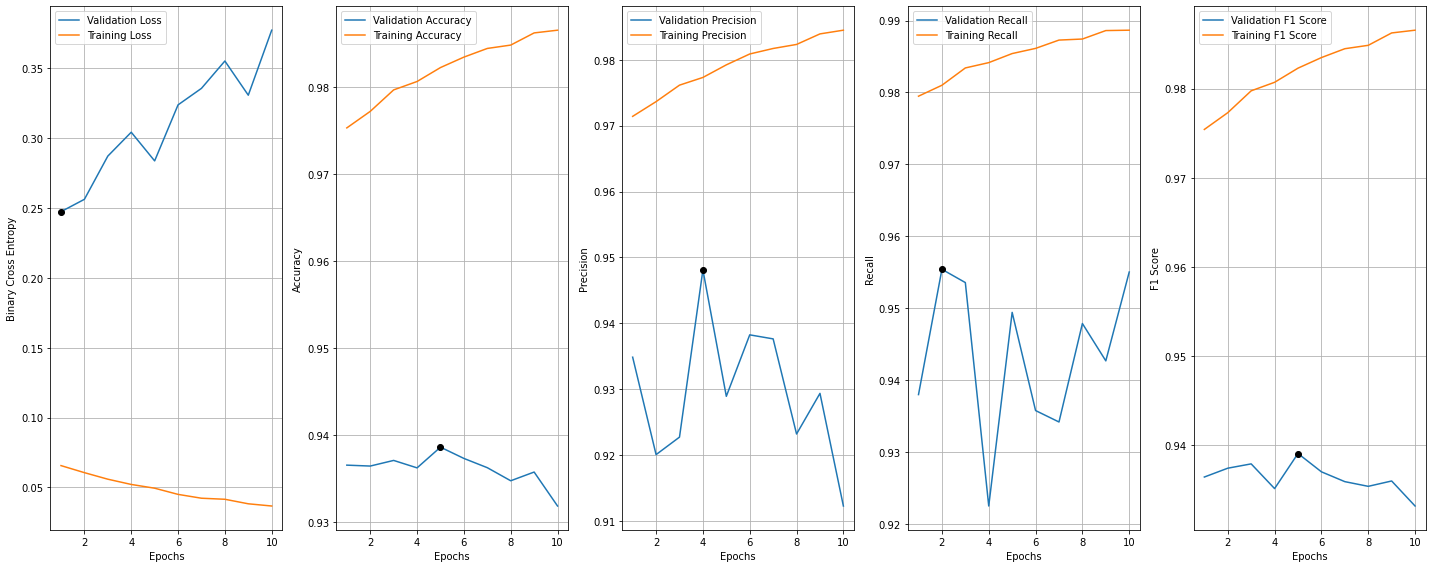

In [ ]:
plot_epochs_against_metrics_and_loss(baseline_history, n_epochs=EPOCHS)

In [ ]:
test_dir = '/content/non_and_biodegradable_waste_dataset/TEST_C'
test_ds = image_dataset_from_directory(
  directory=test_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 10930 files belonging to 2 classes.


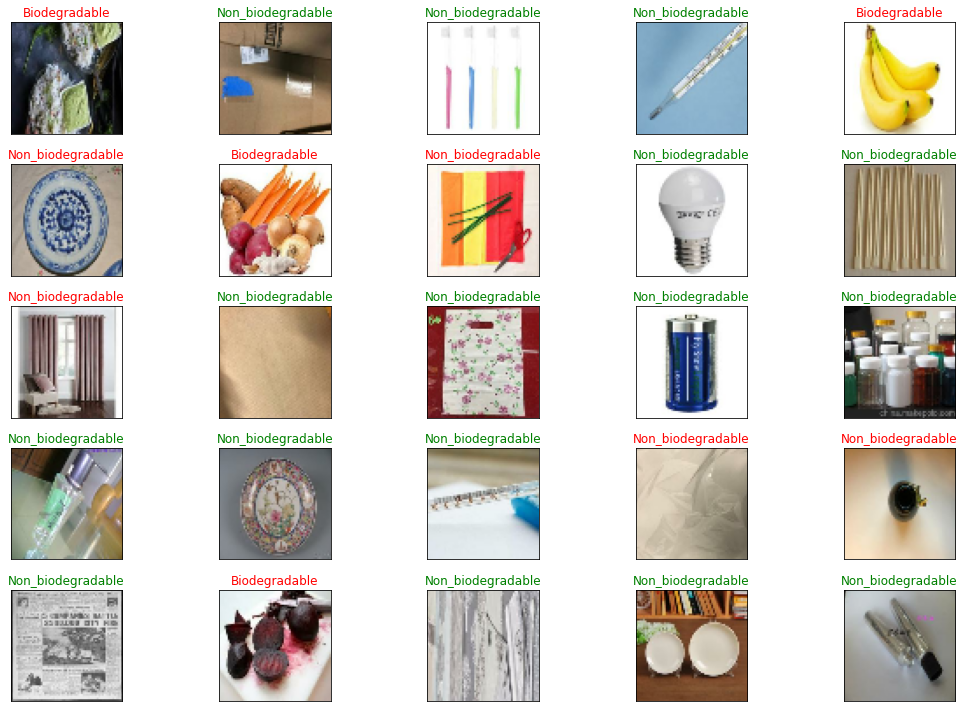

In [ ]:
show_predictions(baseline_model, test_ds)

In [ ]:
baseline_results = print_results(baseline_model, test_ds, 'Baseline')

342/342 [==============================] - 5s 13ms/step - loss: 0.4051 - accuracy: 0.9288 - precision: 0.9488 - recall: 0.9587 - f1_score: 0.9537 - auc: 0.9442
Transfer Learning Model using Baseline
  - Accuracy: 92.88%
  - Precision: 94.88%
  - Recall: 95.87%
  - F1 Score: 95.37%


In [ ]:
correct_labels, predicted_labels = true_and_predicted_labels(baseline_model, test_ds)

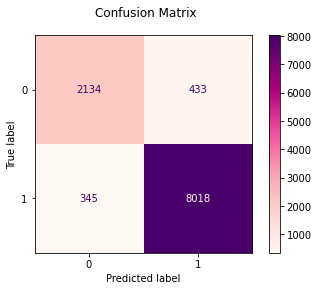

In [ ]:
cm = tf.math.confusion_matrix(correct_labels, predicted_labels).numpy()
show_confusion_matrix(cm=cm)

In [ ]:
y_true, y_baseline_pred = true_and_predicted_labels(baseline_model, test_ds)
print(classification_report(y_true, y_baseline_pred, target_names=class_names))

              precision    recall  f1-score   support

           B       0.86      0.83      0.85      2567
           N       0.95      0.96      0.95      8363

    accuracy                           0.93     10930
   macro avg       0.90      0.90      0.90     10930
weighted avg       0.93      0.93      0.93     10930



In [ ]:
baseline_model.save('baseline-model-final.h5')

In [ ]:
! cp 'baseline-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

#### Naive Approach vs. Baseline Model

##### Before the Data Augmentation (with the imbalance)

In [ ]:
total_bfda = len(test_bio_images_bfda) + len(test_non_bio_images_bfda)
len(test_bio_images_bfda) / total_bfda, len(test_non_bio_images_bfda) / total_bfda

(0.23485818847209516, 0.7651418115279048)

In [ ]:
y_test_bfda = np.concatenate([np.zeros(len(test_bio_images_bfda)), np.ones(len(test_non_bio_images_bfda))])
y_naive_preds_bfda = np.ones(y_test_bfda.shape)

print(f"Accuracy: {accuracy_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"Recall: {recall_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"Precision: {precision_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"F1 Score: {f1_score(y_test_bfda, y_naive_preds_bfda)}")

Accuracy: 0.7651418115279048
Recall: 1.0
Precision: 0.7651418115279048
F1 Score: 0.8669465609288344


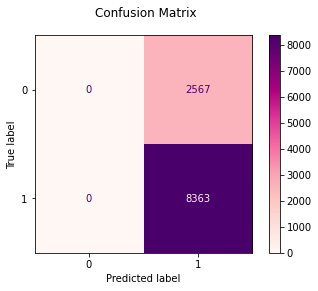

In [ ]:
show_confusion_matrix(y_test_bfda, y_naive_preds_bfda)

##### After the Data Augmentation

In [ ]:
total_afda = len(test_bio_images_afda) + len(test_non_bio_images_afda)
len(test_bio_images_afda) / total_afda, len(test_non_bio_images_afda) / total_afda

(0.23485818847209516, 0.7651418115279048)

In [ ]:
y_test_afda = np.concatenate([np.zeros(len(test_bio_images_afda)), np.ones(len(test_non_bio_images_afda))])
y_naive_preds_afda = np.ones(y_test_afda.shape)

print(f"Accuracy: {accuracy_score(y_test_afda, y_naive_preds_afda)}")
print(f"Recall: {recall_score(y_test_afda, y_naive_preds_afda)}")
print(f"Precision: {precision_score(y_test_afda, y_naive_preds_afda)}")
print(f"F1 Score: {f1_score(y_test_afda, y_naive_preds_afda)}")

Accuracy: 0.7651418115279048
Recall: 1.0
Precision: 0.7651418115279048
F1 Score: 0.8669465609288344


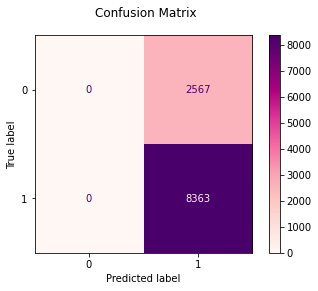

In [ ]:
show_confusion_matrix(y_test_afda, y_naive_preds_afda)

## VGG16

In [ ]:
! mkdir -p models/tmp
! mkdir logs

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
if os.path.exists('vgg16-model.h5'):
  from_vgg_model = load_model('vgg16-model.h5')
else:
  vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=input_shape)

  from_vgg_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    vgg_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

  vgg_model.trainable = False

  from_vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
from_vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/vgg16-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/vgg16')
]

from_vgg_history = from_vgg_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

Epoch 1/50
5993/5993 [==============================] - 102s 17ms/step - loss: 0.2123 - accuracy: 0.9159 - precision: 0.9071 - recall: 0.9201 - f1_score: 0.9135 - auc: 0.9686 - val_loss: 0.1840 - val_accuracy: 0.9284 - val_precision: 0.9390 - val_recall: 0.9157 - val_f1_score: 0.9272 - val_auc: 0.9806
Epoch 2/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1831 - accuracy: 0.9285 - precision: 0.9253 - recall: 0.9325 - f1_score: 0.9289 - auc: 0.9791 - val_loss: 0.1683 - val_accuracy: 0.9347 - val_precision: 0.9405 - val_recall: 0.9275 - val_f1_score: 0.9340 - val_auc: 0.9829
Epoch 3/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1709 - accuracy: 0.9344 - precision: 0.9312 - recall: 0.9382 - f1_score: 0.9347 - auc: 0.9817 - val_loss: 0.1631 - val_accuracy: 0.9370 - val_precision: 0.9377 - val_recall: 0.9357 - val_f1_score: 0.9367 - val_auc: 0.9836
Epoch 4/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1633 - accura

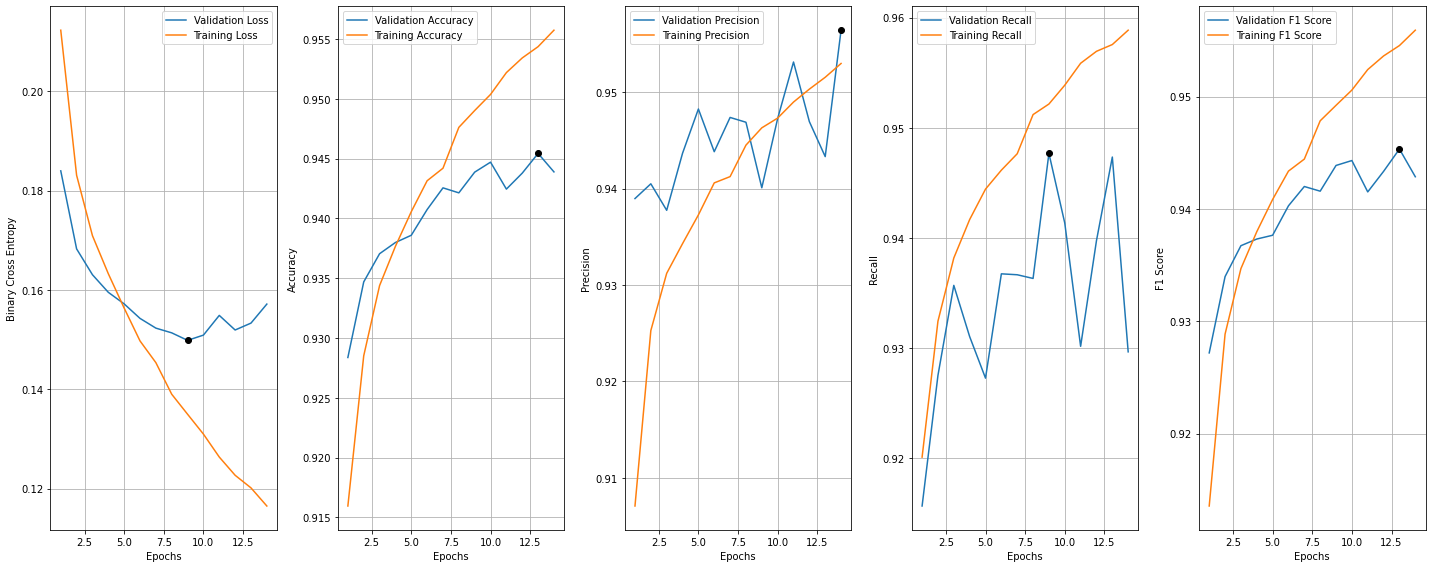

In [ ]:
plot_epochs_against_metrics_and_loss(from_vgg_history, n_epochs=len(from_vgg_history.history['accuracy']))

In [ ]:
%tensorboard --logdir logs

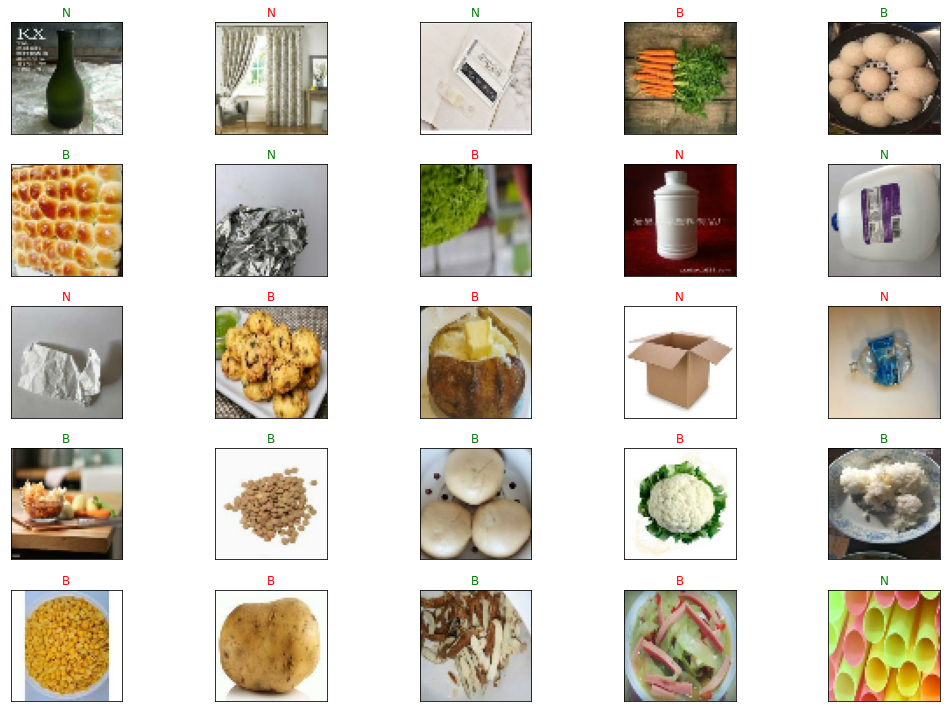

In [ ]:
show_predictions(from_vgg_model, test_ds)

In [ ]:
from_vgg_results = print_results(from_vgg_model, test_ds, 'VGG16')

NameError: ignored

In [ ]:
y_true, y_from_vgg_pred = true_and_predicted_labels(from_vgg_model, test_ds)
print(classification_report(y_true, y_from_vgg_pred, target_names=class_names))

              precision    recall  f1-score   support

           B       0.80      0.88      0.84      2567
           N       0.96      0.93      0.95      8363

    accuracy                           0.92     10930
   macro avg       0.88      0.91      0.89     10930
weighted avg       0.92      0.92      0.92     10930



In [ ]:
from_vgg_model.save('vgg16-model-final.h5')

In [ ]:
! cp 'vgg16-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

### Fine Tuning

In [ ]:
from_vgg_model.trainable = True

for layer in from_vgg_model.layers[:15]:
  layer.trainable = False

vgg_fine_tuned_model = Sequential([
  from_vgg_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.5),
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

vgg_fine_tuned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/vgg16-fine-tuned-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs')
]

vgg_fine_tuned_history = vgg_fine_tuned_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

Epoch 1/50
 453/5993 [=>............................] - ETA: 1:41 - loss: 0.1770 - accuracy: 0.9476 - precision: 0.9517 - recall: 0.9437 - f1_score: 0.9477 - auc: 0.9686

KeyboardInterrupt: ignored

In [ ]:
plot_epochs_against_metrics_and_loss(vgg_fine_tuned_history, n_epochs=len(vgg_fine_tuned_history.history['accuracy']))

In [ ]:
show_predictions(vgg_fine_tuned_model, test_ds)

In [ ]:
print_results(vgg_fine_tuned_model, test_ds, 'VGG16 Fine-Tuned')

## EfficientNet

In [ ]:
import os

In [ ]:
if os.path.exists('efficientnet-model.h5'):
  from_efficientnet_model = load_model('efficientnet-model.h5')
else:
  efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")

  from_efficientnet_model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

  efficientnet_model.trainable = False

  from_efficientnet_model.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/efficientnet-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/efficientnet')
]

from_efficientnet_history = from_efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

Epoch 1/50
5458/5993 [==========================>...] - ETA: 21s - loss: 0.1380 - accuracy: 0.9569 - precision: 0.9528 - recall: 0.9615 - f1_score: 0.9572

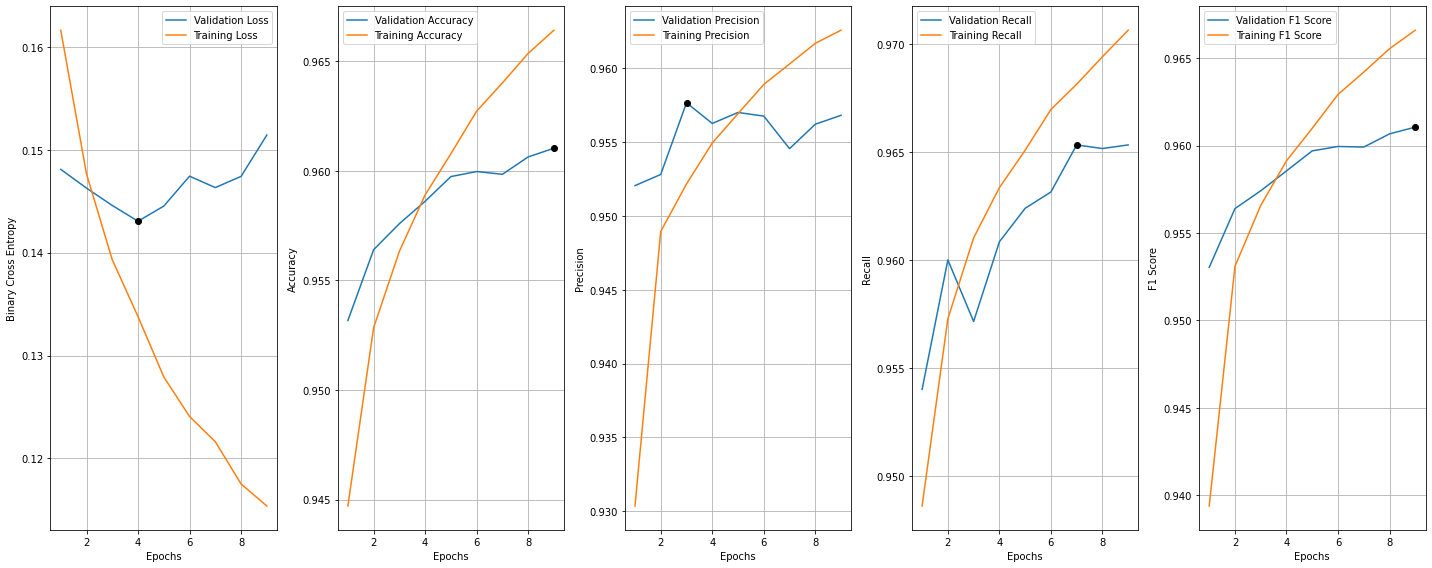

In [ ]:
plot_epochs_against_metrics_and_loss(from_efficientnet_history, n_epochs=len(from_efficientnet_history.history['accuracy']))

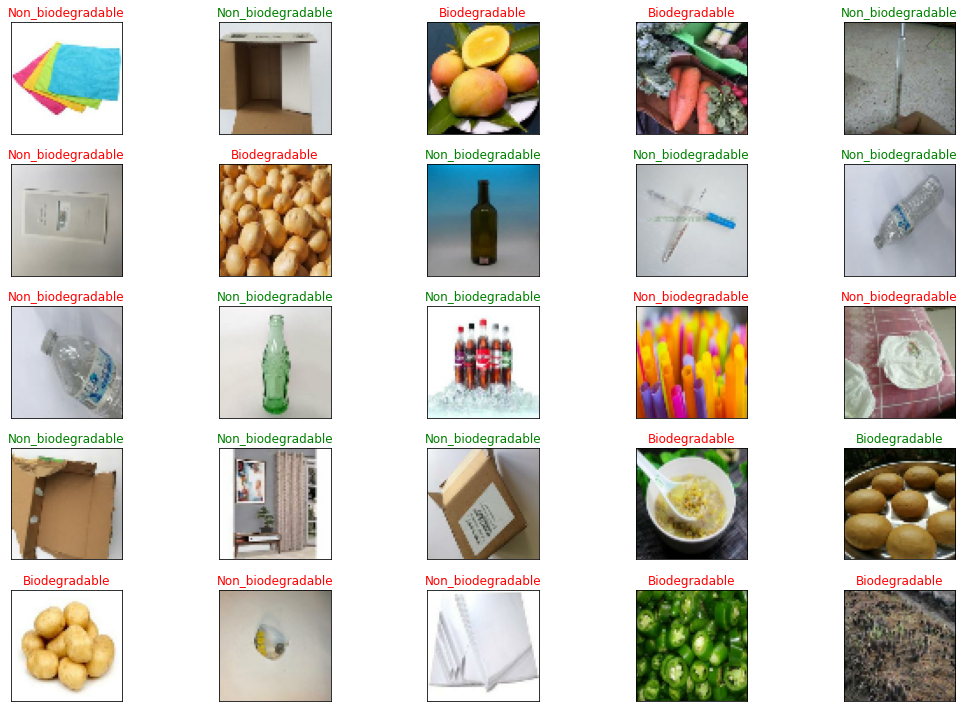

In [ ]:
show_predictions(from_efficientnet_model, test_ds)

In [ ]:
from_efficientnet_results = print_results(from_efficientnet_model, test_ds, 'ResNet 50')

342/342 [==============================] - 7s 17ms/step - loss: 0.2114 - accuracy: 0.9311 - precision: 0.9644 - recall: 0.9449 - f1_score: 0.9545


ValueError: ignored

In [ ]:
y_true, y_from_efficientnet_pred = true_and_predicted_labels(from_efficientnet_model, test_ds)
print(classification_report(y_true, y_from_efficientnet_pred, target_names=class_names))

              precision    recall  f1-score   support

           B       0.83      0.89      0.86      2567
           N       0.96      0.94      0.95      8363

    accuracy                           0.93     10930
   macro avg       0.90      0.92      0.91     10930
weighted avg       0.93      0.93      0.93     10930



In [ ]:
from_efficientnet_model.save('efficientnet-model-final.h5')

In [ ]:
! cp 'efficientnet-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

## Inception

In [ ]:
input_shape = (75, 75, 3)
image_size = input_shape[:2]

train_ds_inception = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='training',
  image_size=image_size,
  batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

val_ds_inception = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='validation',
  image_size=image_size,
  batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Found 239690 files belonging to 2 classes.
Using 191752 files for training.
Found 239690 files belonging to 2 classes.
Using 47938 files for validation.


In [ ]:
if os.path.exists('inception-v3-model.h5'):
  from_inception_v3_model = load_model('inception-v3-model.h5')
else:
  inception_v3_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=input_shape)

  from_inception_v3_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    inception_v3_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

  inception_v3_model.trainable = False

  from_inception_v3_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/inception-v3-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/inceptionv3')
]

from_inception_v3_history = from_inception_v3_model.fit(
  train_ds_inception,
  validation_data=val_ds_inception,
  epochs=50,
  steps_per_epoch=len(train_ds_inception),
  validation_steps=len(val_ds_inception),
  callbacks=callbacks)

Epoch 1/50
5993/5993 [==============================] - 237s 37ms/step - loss: 0.2245 - accuracy: 0.9137 - precision: 0.9079 - recall: 0.9209 - f1_score: 0.9144 - auc: 0.9694 - val_loss: 0.1914 - val_accuracy: 0.9279 - val_precision: 0.9213 - val_recall: 0.9351 - val_f1_score: 0.9281 - val_auc: 0.9770
Epoch 2/50
5993/5993 [==============================] - 172s 29ms/step - loss: 0.1805 - accuracy: 0.9341 - precision: 0.9290 - recall: 0.9401 - f1_score: 0.9345 - auc: 0.9797 - val_loss: 0.1858 - val_accuracy: 0.9335 - val_precision: 0.9290 - val_recall: 0.9381 - val_f1_score: 0.9336 - val_auc: 0.9787
Epoch 3/50
5993/5993 [==============================] - 171s 29ms/step - loss: 0.1626 - accuracy: 0.9431 - precision: 0.9379 - recall: 0.9492 - f1_score: 0.9435 - auc: 0.9834 - val_loss: 0.1869 - val_accuracy: 0.9352 - val_precision: 0.9293 - val_recall: 0.9414 - val_f1_score: 0.9354 - val_auc: 0.9791
Epoch 4/50
5993/5993 [==============================] - 170s 28ms/step - loss: 0.1482 - acc

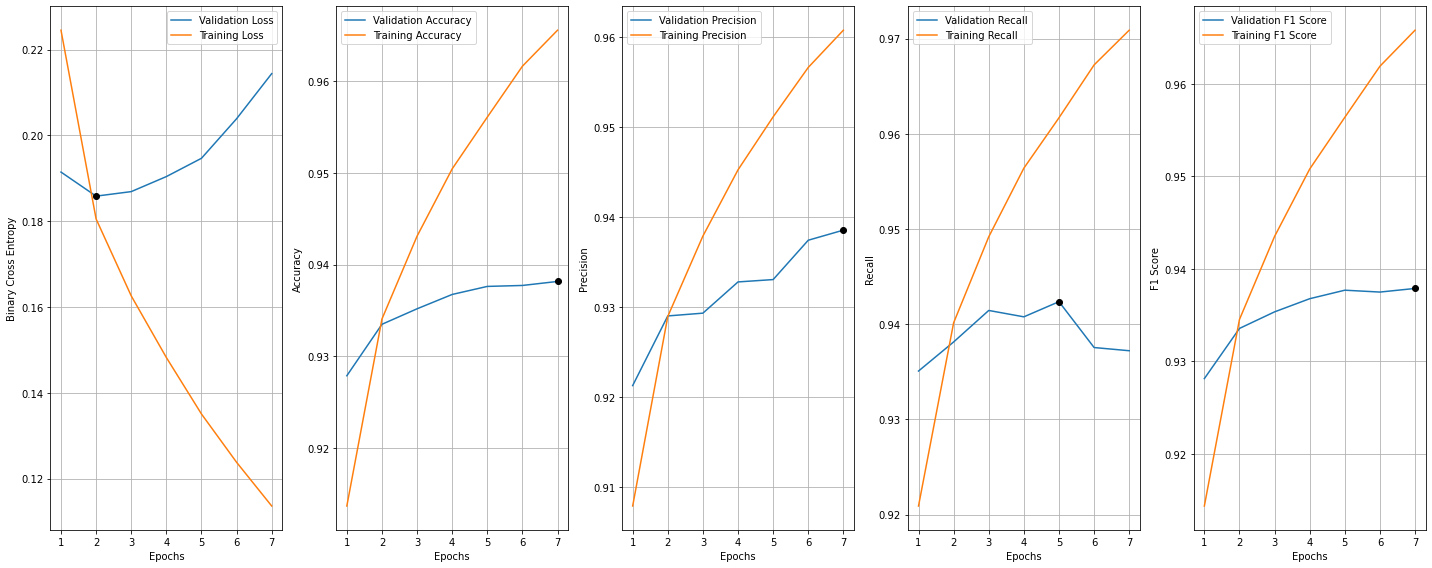

In [ ]:
plot_epochs_against_metrics_and_loss(from_inception_v3_history, n_epochs=len(from_inception_v3_history.history['accuracy']))

In [ ]:
test_ds_inception = image_dataset_from_directory(
  directory=test_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 10930 files belonging to 2 classes.


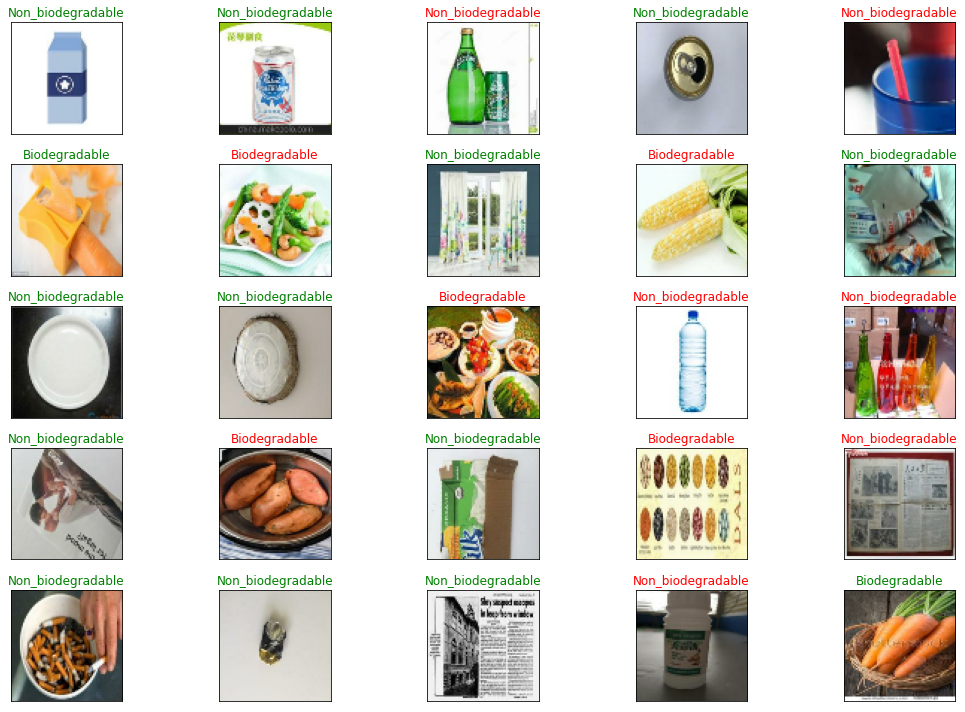

In [ ]:
show_predictions(from_inception_v3_model, test_ds_inception)

In [ ]:
from_inception_v3_results = print_results(from_inception_v3_model, test_ds_inception, 'Inception V3')

342/342 [==============================] - 7s 21ms/step - loss: 0.2403 - accuracy: 0.9131 - precision: 0.9552 - recall: 0.9300 - f1_score: 0.9424


ValueError: ignored

In [ ]:
y_true, y_from_inception_v3_pred = true_and_predicted_labels(from_inception_v3_model, test_ds_inception)
print(classification_report(y_true, y_from_inception_v3_pred, target_names=class_names))

              precision    recall  f1-score   support

           B       0.79      0.86      0.82      2567
           N       0.96      0.93      0.94      8363

    accuracy                           0.91     10930
   macro avg       0.87      0.89      0.88     10930
weighted avg       0.92      0.91      0.91     10930



In [ ]:
from_inception_v3_model.save('inception-v3-model-final.h5')

In [ ]:
! cp 'inception-v3-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

# ROC Curve Analysis

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
baseline_results

('Baseline',
 0.9215004444122314,
 0.9499940276145935,
 0.9472677111625671,
 0.9486289024353027,
 0.9573963284492493)

NameError: ignored

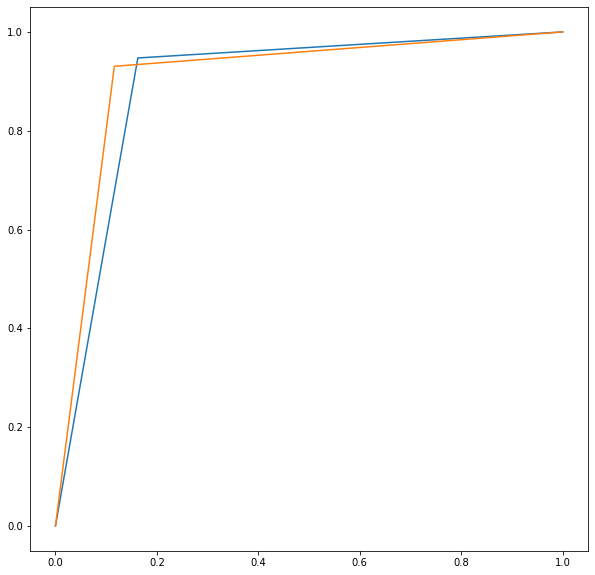

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))

def plot_roc_curve(prefix, test_ds, ax):
  [model_name, _, _, _, _, auc_score] = eval(f'{prefix}_results')
  model = eval(f'{prefix}_model')
  y_true, y_pred = true_and_predicted_labels(model, test_ds)

  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  ax.plot(fpr, tpr, label=f'{model_name} - AUC Score={auc_score}')

for prefix in ['baseline', 'from_vgg', 'from_efficientnet', 'from_inception_v3']:
  if 'inception' in prefix:
    plot_roc_curve(prefix, test_ds_inception, ax)
    continue

  plot_roc_curve(prefix, test_ds, ax)

ax.plot([0, 1], [0, 1], color='orange', linestyle='--')

ax.set(xticks=np.arange(0.0, 1.1, step=0.1), xlabel="False Positive Rate", yticks=np.arange(0.0, 1.1, step=0.1), ylabel="True Positive Rate")

ax.set_title('ROC Curve Analysis', fontweight='bold', fontsize=15)

ax.legend(prop={'size': 13}, loc='lower right')

plt.show()

# Presentation

In [ ]:
! pip install gradio -q

     |████████████████████████████████| 649 kB 5.2 MB/s 
     |████████████████████████████████| 210 kB 66.1 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 255 kB 60.6 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 2.0 MB 38.6 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 64.0 MB/s 
     |████████████████████████████████| 144 kB 67.2 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 10.9 MB 38.2 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 3.6 MB 53.8 MB/s 
     |████████████████████████████████| 61 kB 443 kB/s 
     |████████████████████████

In [ ]:
import gradio as gr

In [ ]:
def classify_image(model):
  def fn_classify_image(img):
    inp = img.reshape((-1, 64, 64, 3))
    confidence = model.predict(inp).flatten()
    outputs = {0: '🌱 Biodegradable', 1: '💀 Non-biodegradable'}
    return outputs[int(confidence >= 0.5)]
  return fn_classify_image

In [ ]:
# ! pip install shap -q
# import shap

In [ ]:
image = gr.inputs.Image(shape=(64, 64))
# interpretation="shap"
iface = gr.Interface(fn=classify_image(baseline_model), inputs=image, outputs="text", interpretation="default")
debug=True
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://43316.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f7d279ffc90>,
 'http://127.0.0.1:7861/',
 'https://43316.gradio.app')

# Flush and Unmount Google Drive

In [ ]:
drive.flush_and_unmount()

# More (useful) Resources

- Image Classification Fine-Tuning: https://huggingface.co/tasks/image-classification

#### CLIP image classifying

In [ ]:
! pip install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
     |████████████████████████████████| 53 kB 1.5 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zdc1ksip
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-zdc1ksip
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=34efd67a79f76848d7afb81658046a7e97b56a860b035a6020abf0c2dc25544a
  Stored in directory: /tmp/pip-ephem-wheel-cache-iri_yx68/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import torch
import clip
from PIL import Image
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision, os

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 194MiB/s]


In [ ]:
labels = ['B','N']
tkns  = ['Biodegradable','Non biodegradable']
text = clip.tokenize(tkns).to(device)

In [ ]:
def get_features(dataset):
    all_features = []
    all_labels = []
    results = []
    with torch.no_grad():
        for images, t in tqdm(DataLoader(dataset, batch_size=100)):

            image_features = model.encode_image(images.to(device))
            logits_per_image, logits_per_text = model(images.to(device), text)

            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            results.append(probs)

    return results

In [ ]:
results = []
pre_proclist = []

BATCH_SIZE = 900
directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Mixed'
ln = len([name for name in os.listdir(directory)])

def walk_dirs(directory, batch_size):
    walk_dirs_generator = os.walk(directory)
    for dirname, subdirectories, filenames in walk_dirs_generator:
        for i in range(0, len(filenames), batch_size):
            # slice the filenames list 0-31, 32-64 and so on
            yield [os.path.join(dirname, filename) for filename in filenames[i:i+batch_size]]

for file_name_batch in walk_dirs(directory, BATCH_SIZE):
    for file_name in file_name_batch:
        # Do some processing on the batch now
        pre_proclist.append(file_name)



In [ ]:
results = []


for i in tqdm(range(0,ln,BATCH_SIZE)):
    images = [
        preprocess(
            Image.open(file)
        ) for file in pre_proclist[i:i+BATCH_SIZE]
    ]
    image_input = torch.tensor(np.stack(images)).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        logits_per_image, logits_per_text = model(image_input, text)
        # The softmax function takes the original confidence and applys a transform to make all the confidence add up to one
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        results.append(probs)

100%|██████████| 13/13 [01:40<00:00,  7.72s/it]


In [ ]:
res = np.concatenate(results,axis=0)
choices = np.argmax(res,axis=1)
choices.shape

(10930,)

In [ ]:
#getlabel = lambda x:labels[x]
#vgetlabel = np.vectorize(getlabel)
#material = vgetlabel(choices)
#len(material)
#np.unique(material, return_counts=True)
choices


array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Biodegradable'
len([name for name in os.listdir(directory)])

2567

In [ ]:
directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable'
len([name for name in os.listdir(directory)])

8363

### Training

In [ ]:
#directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Mixed'
#ln = len([name for name in os.listdir(directory)])

def walk_dirs(directory, batch_size):
    walk_dirs_generator = os.walk(directory)
    for dirname, subdirectories, filenames in walk_dirs_generator:
        for i in range(0, len(filenames), batch_size):
            # slice the filenames list 0-31, 32-64 and so on
            yield [os.path.join(dirname, filename) for filename in filenames[i:i+batch_size]]

def create_list_with_labels(directory, class_label):
  pre_proclist = []
  BATCH_SIZE = 900
  label_dict = {"B": 0 , "N" :1}
  current_class = label_dict[class_label]
  for file_name_batch in walk_dirs(directory, BATCH_SIZE):
    for file_name in file_name_batch:
        # Do some processing on the batch now
        pre_proclist.append((file_name, current_class))
  return pre_proclist

directory = '/content/non_and_biodegradable_waste_dataset/TRAIN/B'
class_label = 'B'
biodegradable_list = create_list_with_labels(directory, class_label)
biodegradable_list[1:10]

directory = '/content/non_and_biodegradable_waste_dataset/TRAIN/N'
class_label = 'N'
non_biodegradable_list = create_list_with_labels(directory, class_label)
non_biodegradable_list[1:10]

[('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.3_NBIODEG_CCW_3893.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.1_NBIODEG_ORI_2487.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.2_NBIODEG_VFL_3540.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.2_NBIODEG_HFL_2387.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.2_NBIODEG_ORI_1929.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.3_NBIODEG_ORI_1074.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.1_NBIODEG_CCW_5517.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.1_NBIODEG_CCW_3696.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TRAIN/N/TRAIN.4_NBIODEG_CWR_2659.jpg',
  1)]

In [ ]:
train_all_images = biodegradable_list + non_biodegradable_list
train_all_pre_proclist = [i[0] for i in train_all_images]
train_all_labels = np.array([i[1] for i in train_all_images])

#train_b_path  = [i[0] for i in biodegradable_list]
#train_b_class = [i[1] for i in biodegradable_list]
#train_n_path  = [i[0] for i in non_biodegradable_list]
#train_n_class = [i[1] for i in non_biodegradable_list]
#train_pre_proclist = b_path + n_path
#train_labels = train_b_class + 
all_features = []
BATCH_SIZE = 900

ln = len(train_all_pre_proclist)

for i in tqdm(range(0,ln,BATCH_SIZE)):
    images = [
        preprocess(
            Image.open(file)
        ) for file in train_all_pre_proclist[i:i+BATCH_SIZE]
    ]
    image_input = torch.tensor(np.stack(images)).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        all_features.append(image_features)

100%|██████████| 267/267 [25:39<00:00,  5.77s/it]


In [ ]:
train_features = torch.cat(all_features).cpu().numpy()
len(train_features)

239690

In [ ]:
len(train_all_pre_proclist)

239690

In [ ]:
train_features.shape

(239690, 512)

### Test

In [ ]:
directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Biodegradable'
class_label = 'B'
biodegradable_list = create_list_with_labels(directory, class_label)

directory = '/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable'
class_label = 'N'
non_biodegradable_list = create_list_with_labels(directory, class_label)
non_biodegradable_list[1:10]

[('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_2393.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_7570.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_7717.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_2578.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_7901.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_7511.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_2472.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_4498.jpg',
  1),
 ('/content/non_and_biodegradable_waste_dataset/TEST_C/Non_biodegradable/TEST_NBIODEG_ORI_4845.jpg',
  1)]

In [ ]:
test_all_images = biodegradable_list + non_biodegradable_list
test_all_pre_proclist = [i[0] for i in test_all_images]
test_all_labels = np.array([i[1] for i in test_all_images])


all_features = []
BATCH_SIZE = 900

ln = len(test_all_pre_proclist)

for i in tqdm(range(0,ln,BATCH_SIZE)):
    images = [
        preprocess(
            Image.open(file)
        ) for file in test_all_pre_proclist[i:i+BATCH_SIZE]
    ]
    image_input = torch.tensor(np.stack(images)).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        all_features.append(image_features)

100%|██████████| 13/13 [01:15<00:00,  5.78s/it]


In [ ]:
test_features = torch.cat(all_features).cpu().numpy()
len(test_features)

10930

In [ ]:
len(test_all_labels)

10930

In [ ]:
test_features.shape

(10930, 512)

In [ ]:
type(train_features)

numpy.ndarray

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000)
classifier.fit(train_features, train_all_labels)

LogisticRegression(C=0.316, max_iter=1000, random_state=0)

In [ ]:
predictions = classifier.predict(test_features)

In [ ]:
predictions

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Biodegradable', 'Non biodegradable']
print(classification_report(test_all_labels, predictions, target_names=target_names))

                   precision    recall  f1-score   support

    Biodegradable       0.96      0.97      0.96      2567
Non biodegradable       0.99      0.99      0.99      8363

         accuracy                           0.98     10930
        macro avg       0.97      0.98      0.98     10930
     weighted avg       0.98      0.98      0.98     10930



In [ ]:
len(test_features)

10930

In [ ]:
len(predictions)

10930

In [ ]:
pip install gradio

     |████████████████████████████████| 658 kB 9.3 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 210 kB 58.7 MB/s 
     |████████████████████████████████| 2.0 MB 32.7 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 255 kB 60.0 MB/s 
     |████████████████████████████████| 144 kB 56.5 MB/s 
     |████████████████████████████████| 271 kB 52.7 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 10.9 MB 46.8 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 34.4 MB/s 
     |████████████████████████████████| 61 kB 436 kB/s 
     |████████████████████████

In [ ]:
import gradio as gr
from joblib import load

#MODEL_FILENAME = 'lr-model.pkl'
#model = load(MODEL_FILENAME)


def classify_image(img):
  #inp = img.reshape((-1, 64, 64, 3))
  im = Image.fromarray(img, mode="RGB")
  image_pre_process = [preprocess(im)]
  image_input = torch.tensor(np.stack(image_pre_process)).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image_input)
  image_data = image_features.cpu().numpy()      

  pred = classifier.predict(image_data)
  outputs = {0: '🌱 Biodegradable', 1: '💀 Non-biodegradable'}
  return outputs[int(pred >= 0.5)]
  
image = gr.inputs.Image(shape=(64,64))
iface = gr.Interface(fn=classify_image, inputs=image, outputs="text", interpretation="default")
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://23472.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f8540151a10>,
 'http://127.0.0.1:7861/',
 'https://23472.gradio.app')